In [1]:
import numpy as np
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from sympy import *
from sympy.physics.mechanics import *
from ConditionalDynamic import *

### 系统建模

In [2]:
m1, m2, l1, l2, g = symbols("m1, m2, l1, l2, g")
q1, q2, u1, u2 = dynamicsymbols("q1, q2, u1, u2")
q1d, q2d, u1d, u2d = dynamicsymbols("q1, q2, u1, u2", 1)

### 运动学

In [3]:
N = ReferenceFrame("N")
O = Point("O")
O.set_vel(N, 0)
A = N.orientnew("A", "axis", [q1, N.x])
C1 = O.locatenew("C1", Rational(1, 2)*l1*A.y)
display(C1.v2pt_theory(O, N, A))
P = O.locatenew("P", l1*A.y)
display(P.v2pt_theory(O, N, A))
B = A.orientnew("B", "axis", [q2, A.x])
C2 = P.locatenew("P", Rational(1, 2)*l2*B.y)
display(C2.v2pt_theory(P, N, B))
Q = P.locatenew("Q", l2*B.y)
display(Q.v2pt_theory(P, N, B))

l1*q1'/2*A.z

l1*q1'*A.z

l1*q1'*A.z + l2*(q1' + q2')/2*B.z

l1*q1'*A.z + l2*(q1' + q2')*B.z

### 动力学

In [4]:
I1 = Rational(1, 3)*m1*l1**2*(outer(A.x, A.x)+outer(A.z, A.z))
OP = RigidBody("OP", C1, A, m1, (I1, C1))
I2 = Rational(1, 3)*m2*l2**2*(outer(B.x, B.x)+outer(B.z, B.z))
PQ = RigidBody("PQ", C2, B, m2, (I2, C2))
BodyList = [OP, PQ]
ForceList = [(C1, m1*g*N.y), (C2, m2*g*N.y)]

In [5]:
kane = KanesMethod(N, q_ind = [q1, q2], u_ind = [u1, u2], kd_eqs = [q1d - u1, q2d - u2])
f, f_star = kane.kanes_equations(ForceList, BodyList)
display(f)
display(f_star)

d:\python\python37\lib\site-packages\sympy\physics\mechanics\kane.py:539: SymPyDeprecationWarning: 

The kanes_equation() argument order has been deprecated since SymPy
1.1. Use switched argument order to update your code, For example:
kanes_equations(loads, bodies) > kanes_equations(bodies, loads).
instead. See https://github.com/sympy/sympy/issues/10945 for more
info.  The API for kanes_equations() has changed such that the loads
(forces and torques) are now the second argument and is optional with
None being the default.

  issue=10945, deprecated_since_version="1.1").warn()


Matrix([
[-g*l1*m1*sin(q1(t))/2 - g*l1*m2*sin(q1(t)) + g*l2*m2*(-sin(q1(t))*cos(q2(t)) - sin(q2(t))*cos(q1(t)))/2],
[                                             g*l2*m2*(-sin(q1(t))*cos(q2(t)) - sin(q2(t))*cos(q1(t)))/2]])

Matrix([
[l1*l2*m2*(u1(t) + u2(t))**2*sin(q2(t))/2 - l1*l2*m2*u1(t)**2*sin(q2(t))/2 - (l2**2*m2/3 + m2*(l1*l2*cos(q2(t))/2 + l2**2/4))*Derivative(u2(t), t) - (7*l1**2*m1/12 + l2**2*m2/3 + m2*(l1**2 + l1*l2*cos(q2(t)) + l2**2/4))*Derivative(u1(t), t)],
[                                                                                                   -l1*l2*m2*u1(t)**2*sin(q2(t))/2 - 7*l2**2*m2*Derivative(u2(t), t)/12 - (l2**2*m2/3 + m2*(l1*l2*cos(q2(t))/2 + l2**2/4))*Derivative(u1(t), t)]])

### 系统参数

In [6]:
constants = {
    m1: 1., 
    m2: 1., 
    l1: 1., 
    l2: 1., 
    g: 9.8
}
h, eta = 1.5, 0.8

### 二阶加速度

In [7]:
qdds = solve((f+f_star).subs(constants), [u1.diff(), u2.diff()])
display(qdds)

{Derivative(u2(t), t): 1.2*(2.0*(5.0*u1(t)**2*sin(q2(t)) + 49.0*sin(q1(t) + q2(t)))*(6.0*cos(q2(t)) + 13.0) + (6.0*cos(q2(t)) + 7.0)*(10.0*u1(t)*u2(t)*sin(q2(t)) + 5.0*u2(t)**2*sin(q2(t)) - 49.0*sin(q1(t) + q2(t)) - 147.0*sin(q1(t))))/(36.0*cos(q2(t))**2 - 133.0),
 Derivative(u1(t), t): 1.2*(35.0*u1(t)**2*sin(q2(t)) + 15.0*u1(t)**2*sin(2.0*q2(t)) + 70.0*u1(t)*u2(t)*sin(q2(t)) + 35.0*u2(t)**2*sin(q2(t)) + 147.0*sin(q1(t) + 2.0*q2(t)) - 882.0*sin(q1(t)))/(115.0 - 18.0*cos(2.0*q2(t)))}

### 多阶段建模

In [8]:
def dynamic(t, x):
    dx1 = x[2]
    dx2 = x[3]
    p_dict = {q1: x[0], q2: x[1], u1: x[2], u2: x[3]}
    dx3 = qdds[u1.diff()].subs(p_dict)
    dx4 = qdds[u2.diff()].subs(p_dict)
    return np.array([dx1, dx2, dx3, dx4])

In [9]:
def event(t, x):
    return np.cos(x[0])+np.cos(x[0]+x[1])-h

In [10]:
def trans(t, x):
    A = np.array([
        [-np.sin(x[0])-np.sin(x[0]+x[1]), -np.sin(x[0]+x[1])], 
        [np.cos(x[0])+np.cos(x[0]+x[1]), np.cos(x[0]+x[1])]
    ])
    Ainv = np.linalg.inv(A)
    T = kinetic_energy(N, OP, PQ).subs(constants)
    T1 = T.diff(q1d)
    T2 = T.diff(q2d)
    q1d_new, q2d_new = symbols("q1d_new, q2d_new")
    sol = solve(Matrix([
            (Ainv[0, 1]*(T1.subs({q1d: q1d_new, q2d: q2d_new})-T1.subs({q1d: x[2], q2d: x[3]}))+Ainv[1, 1]*(T2.subs({q1d: q1d_new, q2d: q2d_new})-T2.subs({q1d: x[2], q2d: x[3]}))).subs({q1: x[0], q2: x[1]}), 
            A[0, 0]*(q1d_new+eta*x[2])+A[0, 1]*(q2d_new+eta*x[3])
        ]), [q1d_new, q2d_new])
    return np.array([x[0], x[1], sol[q1d_new].evalf(), sol[q2d_new].evalf()])

In [11]:
dyn = ConditionalDynamic(dynamic, event, trans)

### 仿真

In [12]:
x0 = np.array([np.pi/2, 0, 0, 0])
t_span = [0, 10]
res = dyn.run(x0, t_span)

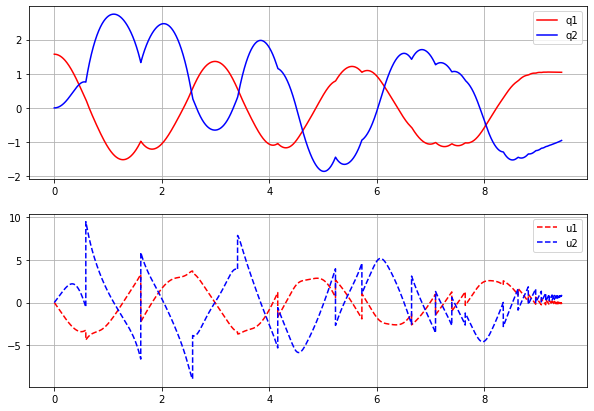

In [13]:
plt.figure(figsize = (10, 7))
plt.subplot(2, 1, 1)
plt.plot(res[0], res[1][0, :], "r-", label = "q1")
plt.plot(res[0], res[1][1, :], "b-", label = "q2")
plt.legend()
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(res[0], res[1][2, :], "r--", label = "u1")
plt.plot(res[0], res[1][3, :], "b--", label = "u2")
plt.legend()
plt.grid()
plt.show()

### 生成动画

In [14]:
def datas(i):
    q1i = res[1][0, 100*i]
    q2i = res[1][1, 100*i]
    pO = np.array([0., 0.])
    pP = np.array([np.cos(q1i), np.sin(q1i)])
    pQ = pP + np.array([np.cos(q1i+q2i), np.sin(q1i+q2i)])
    data = [np.r_[
        np.linspace(pO[1], pP[1], 100), 
        np.linspace(pP[1], pQ[1], 100)
    ], np.r_[
        np.linspace(pO[0], pP[0], 100), 
        np.linspace(pP[0], pQ[0], 100)
    ]]
    return data

In [15]:
def update(i):
    data = datas(i)
    opq.set_data(data)
    return opq, 

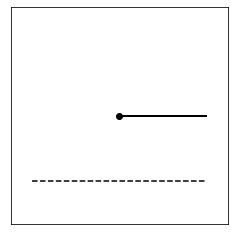

MovieWriter ffmpeg unavailable; using Pillow instead.


In [16]:
fig, ax = plt.subplots()
ax.axis("square")
ax.set_xlim([-2.5, 2.5])
ax.set_ylim([2.5, -2.5])
ax.set_xticks([])
ax.set_yticks([])
opq, = ax.plot([], [], lw = 2, color = "k")
ax.plot(0, 0, "ko")
ax.plot(np.linspace(-2, 2, 100), h*np.ones(100), "k--")
ani = anim.FuncAnimation(fig, update, frames = len(res[0])//100, interval = 100, blit = True)
plt.show()
ani.save("example2.gif", fps = 10)